In [1]:
# preprcessing function

def preprocess_observation(obs):
    img = obs[34:194:2, ::2]
    return np.mean(img,axis=2).reshape(80,80)/255.0

In [4]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("Breakout-v0")
obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)
img = preprocess_observation(obs)

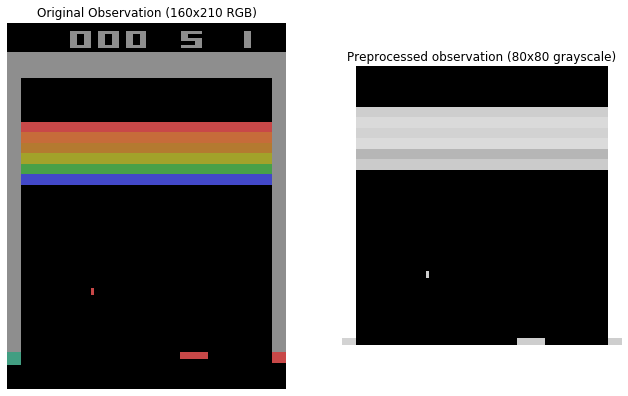

In [5]:
plt.figure(figsize=(11,7))
plt.subplot(121)
plt.title("Original Observation (160x210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (80x80 grayscale)")
plt.imshow(img, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

# here we can see that singleimage doesnot give us the direction and speed of the ball
# which are crucial for playing this game


In [11]:
# so here we need to combine several consecutive observations to create the
# environment state representation
# we can create a multi channel image with one channel per recent observation
# another is to merge all recent observations into a singlechannel images 
# in the case we dim the older images so that Dqn can distinguidh the
# past from the present

from collections import deque

def combine_observations_multichannel(preprocessed_observations):
    return np.array(preprocessed_observations).transpose([1,2,0])

def combine_observations_singlechannel(preprocessed_observations, dim_factor=0.5):
    dimmed_observations = [obs * dim_factor ** index
                           for index, obs in enumerate( reversed(preprocessed_observations))]
    return np.max(np.array(dimmed_observations), axis=0)

n_observations_per_state =  3
preprocessed_observations = deque([], maxlen=n_observations_per_state)

obs = env.reset()
for step in range(10):
    obs, _,_,_ = env.step(1)
    preprocessed_observations.append(preprocess_observation(obs))
    

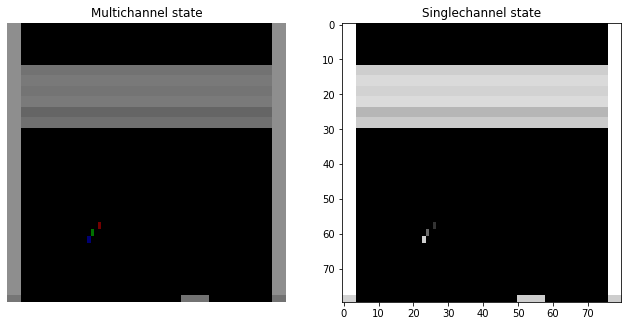

In [12]:
img1 = combine_observations_multichannel(preprocessed_observations)
img2 = combine_observations_singlechannel(preprocessed_observations)

plt.figure(figsize=(11,7))
plt.subplot(121)
plt.title("Multichannel state")
plt.imshow(img1, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.title("Singlechannel state")
plt.imshow(img2, interpolation="nearest", cmap="gray")
plt.show()